# Final Experiments - Single-label SVM Problem Statement - CPU

## Utilities and Imports

In [1]:
%reload_ext autoreload
%autoreload 2

import itertools
from collections import Counter
import numpy as np
import pickle
from operator import itemgetter
import matplotlib
from matplotlib import pyplot as plt

%matplotlib inline
# matplotlib.rcParams['figure.figsize'] = [5, 10]

from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, f1_score
from sklearn.svm import LinearSVC, SVC
from nltk.corpus import stopwords
stop_words = stopwords.words('english')

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

from fastai import text as ft
from fastai import dataloader as fd
from fastai import dataset as fs
from fastai import learner as fl
from fastai import core as fc
from fastai import metrics as fm


from skai.runner import TextRunner, Adam_lambda
from skai.mwrapper import MWrapper, SKModel
from skai.utils import multi_to_text_out, vote_pred
from skai.utils import get_classification_type, weights_init, multilabel_prediction
from skai.dataset import TokenDataset, SimpleDataset


def mapt(f, *iters):
    return tuple(map(f, *iters))

def mapl(f, *iters):
    return list(map(f, *iters))

def manually_remove_problems(data):
    """ remove problem from data if it has a certain tag"""
    final_data = {}
    remove = ['*special']
    for i in data:
        if set(data[i][1][0]).intersection(set(remove)) == set():
            if data[i][0][0] != '':
                final_data[i] = data[i]
    return final_data

def get_single_label_problems(data):
    '''returns a dict of all problems which only have one label'''
    single_label_problems = {}
    for i in data:
        if len(data[i][1][0]) == 1:
            single_label_problems[i] = data[i]
    return single_label_problems

def get_classwise_distribution(data):
    class_count = {}
    for i in data:
        for cls in data[i][1][0]:
            if cls in class_count:
                class_count[cls] +=1 
            else:
                class_count[cls] = 1
    return class_count


def get_topk_single_label_problems(data,k):
    """ get top k by frequency single label problems"""
    class_dict = get_classwise_distribution(data)
    print(class_dict)
    class_dict = dict(sorted(class_dict.items(), key=itemgetter(1), reverse=True)[:k])
    print(set(class_dict.keys()))

    topk_data = {}
    for i in data:
        if set(data[i][1][0]).intersection(set(class_dict.keys())) != set():
            topk_data[i] = data[i]
            
    return topk_data

def make_text_dataset(rdata):
    Xtext, ytext = [], []
    for url, data in rdata.items():
        try:
            ytext.append(data[1][0][0])
        except IndexError:
            continue
        Xtext.append(data[0][0])
    return Xtext, ytext

def make_multi_text_dataset(rdata):
    Xtext, ytext = [], []
    for url, data in rdata.items():
        try:
            ytext.append(data[1][0])
        except IndexError:
            continue
        Xtext.append(data[0][0])
    return Xtext, ytext

def make_statement_dataset(rdata):
    Xtext, ytext = [], []
    for url, data in rdata.items():
        try:
            ytext.append(data[1][0][0])
        except IndexError:
            continue
        Xtext.append(data[0][2])
    return Xtext, ytext

def make_non_statement_dataset(rdata):
    Xtext, ytext = [], []
    for url, data in rdata.items():
        try:
            ytext.append(data[1][0][0])
        except IndexError:
            continue
        Xtext.append(f'{data[0][3]}\n{data[0][4]}\n{data[0][5]}')
    return Xtext, ytext

def get_class_list(labels):
    return list(set(labels))

def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=True,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    cm = confusion_matrix(y_true, y_pred, labels=classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    fig = plt.gcf()
    fig.set_size_inches(22, 16)
    plt.imshow(cm, interpolation='nearest', cmap=cmap, vmin=0.0, vmax=1.0)
#     plt.title(title, fontsize)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, fontsize=32)
    plt.yticks(tick_marks, classes, fontsize=32)

    print(cm.max())
    fmt = '.2f' if normalize else 'd'
    thresh = 0.5
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black",
                 fontsize=32)

    plt.tight_layout()
    plt.ylabel('True label', fontsize=32)
    plt.xlabel('Predicted label', fontsize=32)

/home/aayn/anaconda3/envs/fastai/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


## Load data

In [2]:
top5s = pickle.load(open('data/110_5single_26aug.pkl','rb'))
top10s = pickle.load(open('data/10single_26aug.pkl','rb'))

top5ps, top10ps = mapt(make_statement_dataset, [top5s, top10s])

In [3]:
print(top5ps[1][5])
print(len(top5ps[0]))
print(Counter(top5ps[1]).most_common())

dp
550
[('data structures', 110), ('implementation', 110), ('dp', 110), ('math', 110), ('greedy', 110)]


In [4]:
top5ps[0][4]

"\nIt is winter now, and Max decided it's about time he watered the garden.\nThe garden can be represented as n consecutive garden beds, numbered from 1 to n. k beds contain water taps (i-th tap is located in the bed xi), which, if turned on, start delivering water to neighbouring beds. If the tap on the bed xi is turned on, then after one second has passed, the bed xi will be watered; after two seconds have passed, the beds from the segment [xi\u2009-\u20091,\u2009xi\u2009+\u20091] will be watered (if they exist); after j seconds have passed (j is an integer number), the beds from the segment [xi\u2009-\u2009(j\u2009-\u20091),\u2009xi\u2009+\u2009(j\u2009-\u20091)] will be watered (if they exist). Nothing changes during the seconds, so, for example, we can't say that the segment [xi\u2009-\u20092.5,\u2009xi\u2009+\u20092.5] will be watered after 2.5 seconds have passed; only the segment [xi\u2009-\u20092,\u2009xi\u2009+\u20092] will be watered at that moment.\nThe garden from test 1. 

## SVM Definitions

In [5]:
svm_cv = SKModel(Pipeline(
    [('countvec', CountVectorizer(stop_words=stop_words, max_df=0.25)),
    ('clf', SVC())]),
    {'countvec__ngram_range': [(1, 2)],
    "clf__C": [0.01],
    "clf__class_weight": ['balanced'],
    "clf__kernel": ['linear']})  
svm_cv = MWrapper(svm_cv, 'svm_cv')

Note: Model directory for svm_cv exists.


## Experiments

### 5-class experiments

In [7]:
trunner = TextRunner([svm_cv], top5ps[0], top5ps[1], 'top5ps', make_pyt_data=False)
Xall, yall = np.array(trunner.rdata), np.array(trunner.labels)

Checkpoint reached: raw data cleaned.
multiclass classification.


In [15]:
runs = 1
out_dim = 10

preds_txt_cv, preds_txt_tf = [], []
targs_txt = []

for i in range(runs):
    outer_cv = KFold(n_splits=10, shuffle=True, random_state=i+42)
    
    outer_cv.get_n_splits(Xall, yall)
    for j, (nontest_i, test_i) in enumerate(outer_cv.split(Xall, yall)):
        print(f'Outer split no. {j}')
        X_train, y_train = Xall[nontest_i], yall[nontest_i]
        X_test, y_test = Xall[test_i], yall[test_i]
        
        cv_clf, cv_score = trunner.get_clf_sk(svm_cv, X_train, y_train)        
        preds = cv_clf.predict(X_test)
        preds_txt_cv.append(preds)
        
        targs_txt.append(y_test)

        print(accuracy_score(np.concatenate(targs_txt),
                             np.concatenate(preds_txt_cv)))

preds_txt_cv = np.concatenate(preds_txt_cv)
targs_txt = np.concatenate(targs_txt)

Outer split no. 0
Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=4)]: Done   3 out of   3 | elapsed:    0.4s finished


0.38181818181818183
Outer split no. 1
Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=4)]: Done   3 out of   3 | elapsed:    0.4s finished


0.36363636363636365
Outer split no. 2
Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=4)]: Done   3 out of   3 | elapsed:    0.4s finished


0.3878787878787879
Outer split no. 3
Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=4)]: Done   3 out of   3 | elapsed:    0.4s finished


0.4090909090909091
Outer split no. 4
Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=4)]: Done   3 out of   3 | elapsed:    0.4s finished


0.4072727272727273
Outer split no. 5
Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=4)]: Done   3 out of   3 | elapsed:    0.4s finished


0.403030303030303
Outer split no. 6
Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=4)]: Done   3 out of   3 | elapsed:    0.4s finished


0.4
Outer split no. 7
Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=4)]: Done   3 out of   3 | elapsed:    0.4s finished


0.40454545454545454
Outer split no. 8
Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=4)]: Done   3 out of   3 | elapsed:    0.4s finished


0.402020202020202
Outer split no. 9
Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=4)]: Done   3 out of   3 | elapsed:    0.4s finished


0.4


In [10]:
print(cv_clf.get_params())

{'memory': None, 'steps': [('countvec', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=0.25, max_features=None, min_df=1,
        ngram_range=(1, 2), preprocessor=None,
        stop_words=['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs',... 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", 'won', "won't", 'wouldn', "wouldn't"],
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)), ('clf', SVC(C=0.01, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state

In [2]:
# pickle.dump([preds_txt_cv, targs_txt], open('data/results/svm-ps_5s.pkl', 'wb'))
preds_txt_cv, targs_txt = pickle.load(open('data/results/svm-ps_5s.pkl', 'rb'))

                 precision    recall  f1-score   support

data structures    0.65060   0.49091   0.55959       110
             dp    0.38554   0.29091   0.33161       110
         greedy    0.35955   0.29091   0.32161       110
 implementation    0.32174   0.33636   0.32889       110
           math    0.36111   0.59091   0.44828       110

    avg / total    0.41571   0.40000   0.39799       550

0.4
0.39799290020068384
Normalized confusion matrix
[[0.49091 0.09091 0.08182 0.14545 0.19091]
 [0.08182 0.29091 0.2     0.17273 0.25455]
 [0.02727 0.15455 0.29091 0.23636 0.29091]
 [0.10909 0.1     0.14545 0.33636 0.30909]
 [0.04545 0.11818 0.09091 0.15455 0.59091]]
0.5909090909090909


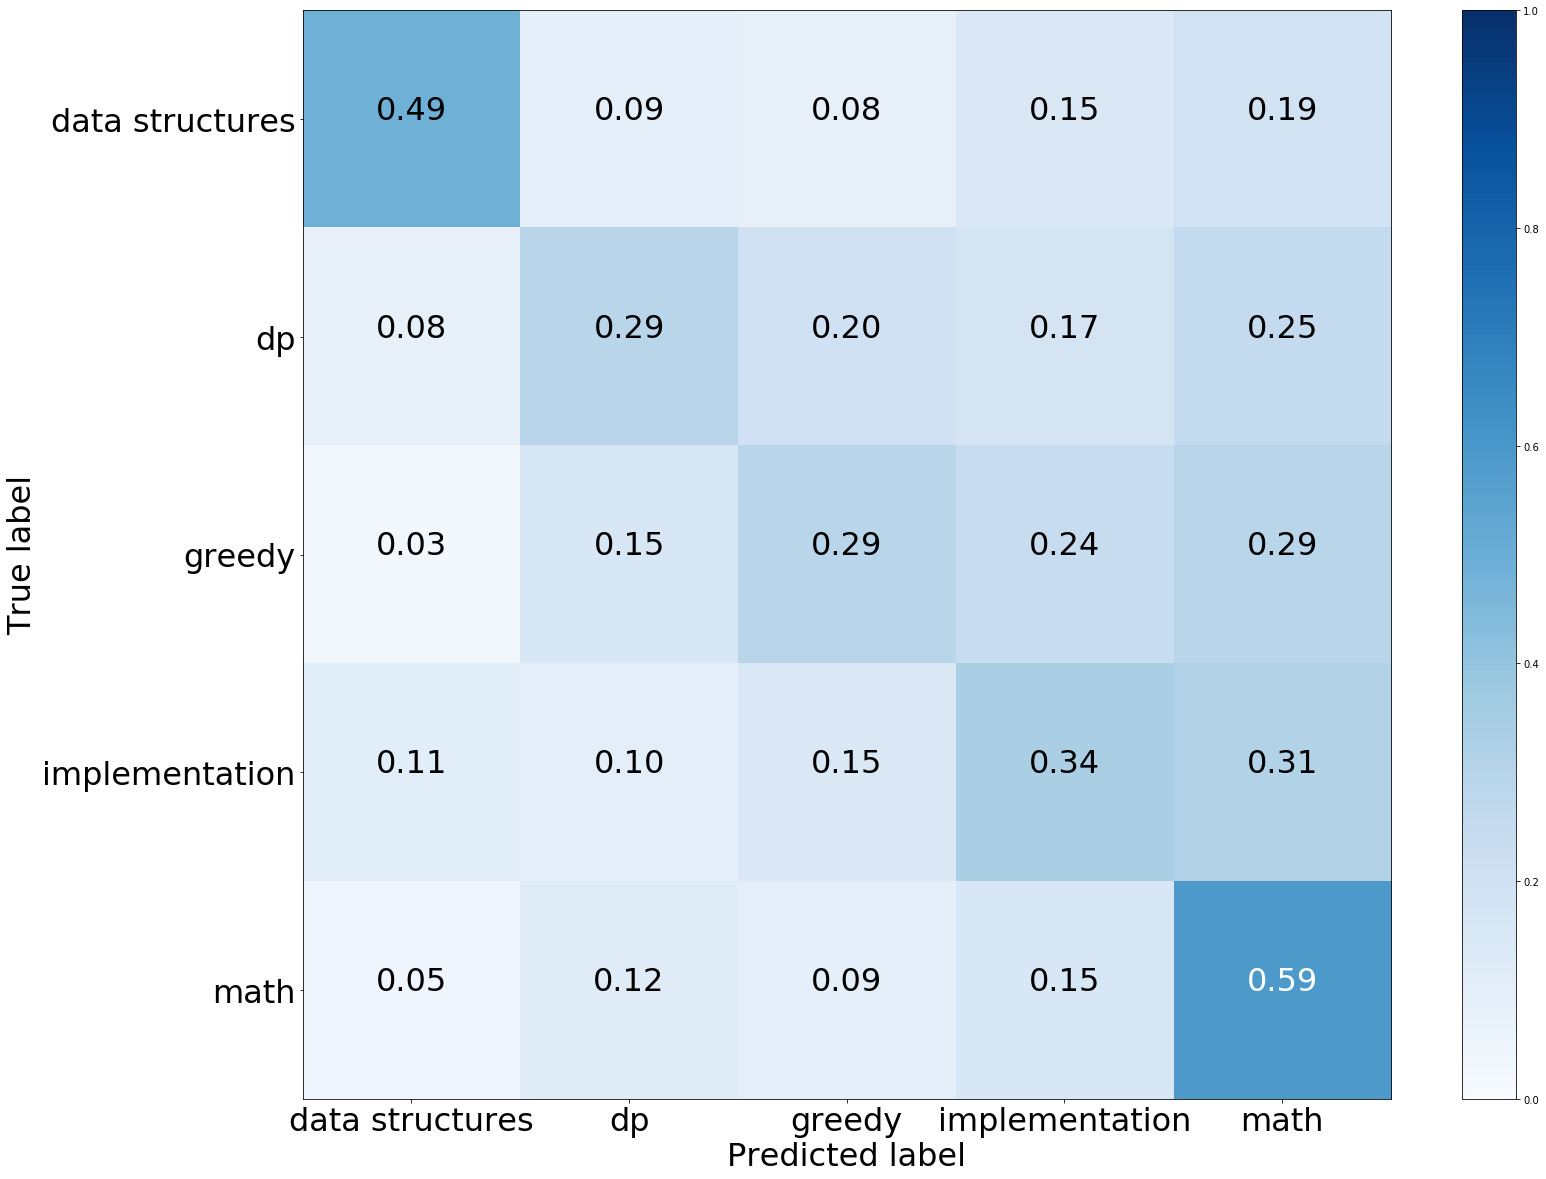

In [3]:
labels = ['data structures', 'dp', 'greedy', 'implementation', 'math']

print(classification_report(targs_txt, preds_txt_cv, labels=labels, digits=5))
print(accuracy_score(targs_txt, preds_txt_cv))
print(f1_score(targs_txt, preds_txt_cv, average='weighted'))
plot_confusion_matrix(targs_txt, preds_txt_cv, labels)